In [1]:
import torch
import model
import trainer
import dataReader
from ensemble import Ensemble
from ensembleTrainer import EnsembleTrainer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from trader import Trader
import pandas as pd
import numpy as np

In [20]:
WINDOW_SIZE = 20
PREDICTION_OFFSET = 1
DATE_RANGE = 365*3
START_DATE = '2017-01-01'
TEST_START_DATE = '2020-01-01'
HIDDEN_SIZE = 100
HIDDEN_COUNT = 1
STEP_COUNT = 1000
STOCK_FILE = '../YFinanceStockData/AAPL.csv'
torch.manual_seed(1)

lstm = model.LSTMModel(torch.nn.ReLU(),WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT)
lstm.init_weights()

cnn = model.CNNModel(1,WINDOW_SIZE,kernel_size=5)
cnn.init_weights()

hybrid = model.HybridModel(WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT,16,8,4)
hybrid.init_weights()

In [18]:
def evaluateLSTMModel(trainer,epochCount,stepCount,train_x,train_y,test_x,unnorm_train_x,unnorm_test_x):
    #epochCount is number of epochs between evaluations
    #stepCount is total number of epochCount size block
    dates = pd.read_csv(STOCK_FILE,usecols=['date'])
    dates = dates[TEST_START_DATE<dates['date']].to_numpy()
    train_result = []
    test_result = []
    losses = []
    for i in range(stepCount):
        losses.append(trainer.train(train_x,train_y,epochCount))
        testTester = Trader(True)
        trainTester = Trader(False)
        testTester.initialCost = unnorm_test_x[0][0][0].item()
        trainTester.initialCost = unnorm_train_x[0][0][0].item()
        trainElementCount = train_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        testElementCount = test_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        lastPrice = 0
        for day in range(trainElementCount):
            prediction = trainer.model(train_x[day]).item()
            day_of = unnorm_train_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            trainTester.actOnPrediction(day_of,next_price,verbose=False)
            lastPrice = day_of
        trainTester.closePositions(lastPrice)
        train_result.append(trainTester.currBalance * 100/trainTester.initialCost)
        for day in range(testElementCount):
            prediction = trainer.model(test_x[day]).item()
            day_of = unnorm_test_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            testTester.actOnPrediction(day_of,next_price,verbose=False,date=dates[day][0])
            lastPrice = day_of
        testTester.closePositions(lastPrice,date=dates[testElementCount-1][0])
        testTester.plotTrades(stockFile=STOCK_FILE)
        test_result.append((testTester.currBalance  /testTester.initialCost)*100)
    return train_result,test_result,losses

def evaluateCNNModel(trainer,epochCount,stepCount,train_x,train_y,test_x,unnorm_train_x,unnorm_test_x):
    #epochCount is number of epochs between evaluations
    #stepCount is total number of epochCount size block
    train_result = []
    test_result = []
    losses = []
    for i in range(stepCount):
        losses.append(trainer.train(train_x,train_y,epochCount,WINDOW_SIZE,6))
        testTester = Trader(True)
        trainTester = Trader(False)
        testTester.initialCost = unnorm_test_x[0][0][0].item()
        trainTester.initialCost = unnorm_train_x[0][0][0].item()
        trainElementCount = train_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        testElementCount = test_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        lastPrice = 0
        for day in range(trainElementCount):
            prediction = trainer.model(train_x[day],WINDOW_SIZE,6).item()
            day_of = unnorm_train_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            trainTester.actOnPrediction(day_of,next_price,verbose=False)
            lastPrice = day_of
        trainTester.closePositions(lastPrice)
        train_result.append(trainTester.currBalance * 100/trainTester.initialCost)
        for day in range(testElementCount):
            prediction = trainer.model(test_x[day],WINDOW_SIZE,6).item()
            day_of = unnorm_test_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            testTester.actOnPrediction(day_of,next_price,verbose=False)
            lastPrice = day_of
        testTester.closePositions(lastPrice)
        test_result.append((testTester.currBalance  /testTester.initialCost)*100)
    return train_result,test_result,losses

def evaluateHybridModel(trainer,epochCount,stepCount,train_x,train_y,test_x,unnorm_train_x,unnorm_test_x):
    #epochCount is number of epochs between evaluations
    #stepCount is total number of epochCount size block
    train_result = []
    test_result = []
    losses = []
    for i in range(stepCount):
        losses.append(trainer.train(train_x,train_y,epochCount))
        testTester = Trader(True)
        trainTester = Trader(False)
        testTester.initialCost = unnorm_test_x[0][0][0].item()
        trainTester.initialCost = unnorm_train_x[0][0][0].item()
        trainElementCount = train_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        testElementCount = test_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        lastPrice = 0
        for day in range(trainElementCount):
            prediction = trainer.model(train_x[day]).item()
            day_of = unnorm_train_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            trainTester.actOnPrediction(day_of,next_price,verbose=False)
            lastPrice = day_of
        trainTester.closePositions(lastPrice)
        train_result.append(trainTester.currBalance * 100/trainTester.initialCost)
        for day in range(testElementCount):
            prediction = trainer.model(test_x[day]).item()
            day_of = unnorm_test_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            testTester.actOnPrediction(day_of,next_price,verbose=False)
            lastPrice = day_of
        testTester.closePositions(lastPrice)
        test_result.append((testTester.currBalance  /testTester.initialCost)*100)
    return train_result,test_result,losses

def evaluateEnsembleModel(trainer,epochCount,stepCount,train_x,train_y,test_x,unnorm_train_x,unnorm_test_x):
    #epochCount is number of epochs between evaluations
    #stepCount is total number of epochCount size block
    train_result = []
    test_result = []
    losses = []
    for i in range(stepCount):
        losses.append(trainer.train(train_x,train_y,epochCount))
        testTester = Trader(True)
        trainTester = Trader(False)
        testTester.initialCost = unnorm_test_x[0][0][0].item()
        trainTester.initialCost = unnorm_train_x[0][0][0].item()
        trainElementCount = train_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        testElementCount = test_x.shape[0] - WINDOW_SIZE - PREDICTION_OFFSET + 1
        lastPrice = 0
        for day in range(trainElementCount):
            prediction = trainer.model(train_x[day]).item()
            day_of = unnorm_train_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            trainTester.actOnPrediction(day_of,next_price,verbose=False)
            lastPrice = day_of
        trainTester.closePositions(lastPrice)
        train_result.append(trainTester.currBalance * 100/trainTester.initialCost)
        for day in range(testElementCount):
            prediction = trainer.model(test_x[day]).item()
            day_of = unnorm_test_x[day][0][WINDOW_SIZE - 1].item()
            next_price = prediction * day_of / 100
            testTester.actOnPrediction(day_of,next_price,verbose=False)
            lastPrice = day_of
        testTester.closePositions(lastPrice)
        test_result.append((testTester.currBalance  /testTester.initialCost)*100)
    return train_result,test_result,losses

def plotStats(trainData,testData,lossData,steps,stepSize):
    xAxis = [i * stepSize for i in range(steps)]
    plt.plot(xAxis,trainData,'r',label='Train Data')
    plt.plot(xAxis,testData,'b',label='Test data')
    plt.xlabel('Steps')
    plt.ylabel('% Change from Initial')
    plt.title('Trader Profits and Losses')
    plt.legend()
    plt.show()
    plt.plot(xAxis,lossData,'g')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Model Training Loss')
    plt.show()


100%|██████████| 40/40 [00:08<00:00,  4.94it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]


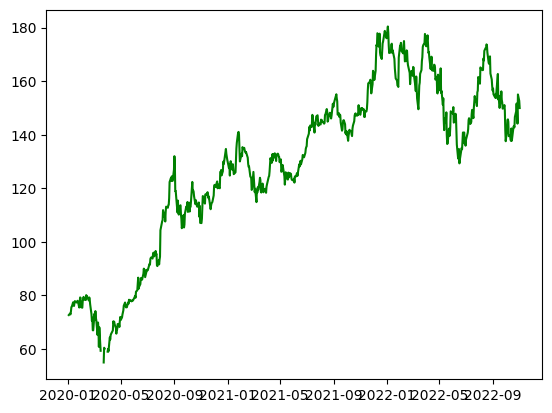

100%|██████████| 40/40 [00:08<00:00,  4.88it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

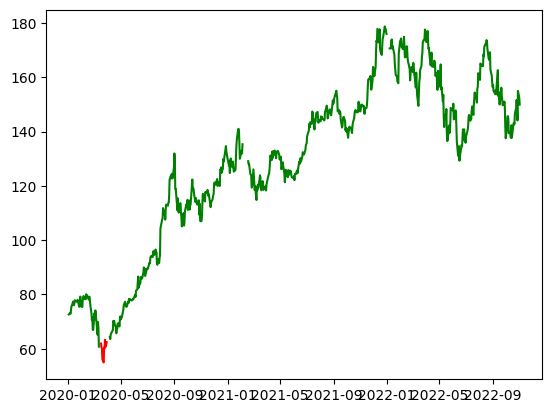

100%|██████████| 40/40 [00:08<00:00,  4.72it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

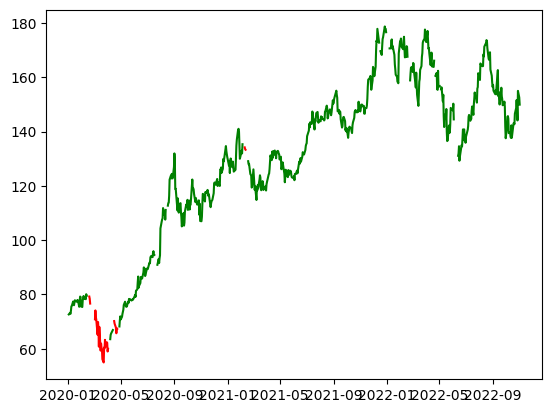

100%|██████████| 40/40 [00:08<00:00,  4.90it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

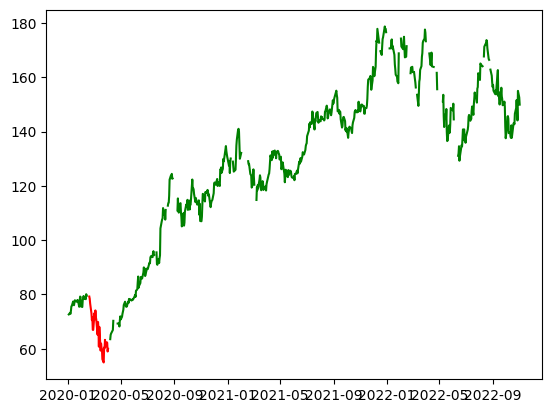

100%|██████████| 40/40 [00:08<00:00,  4.98it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

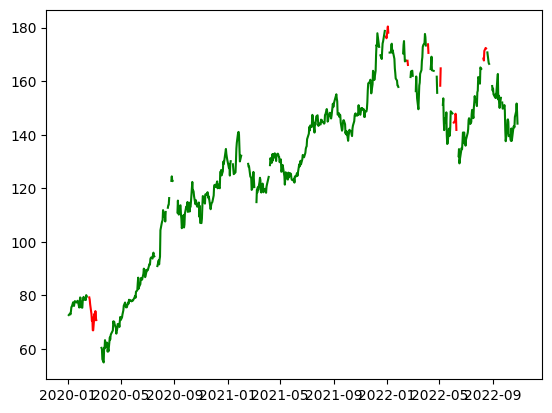

100%|██████████| 40/40 [00:08<00:00,  4.84it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

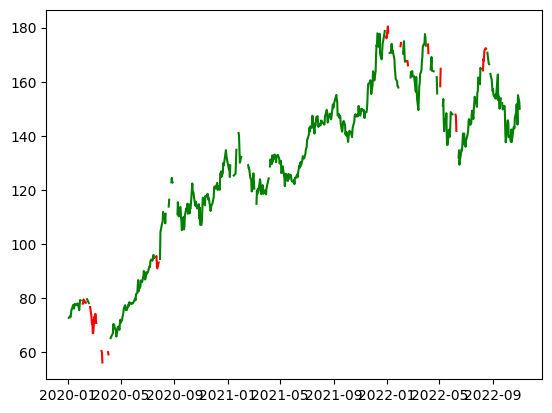

100%|██████████| 40/40 [00:08<00:00,  4.98it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

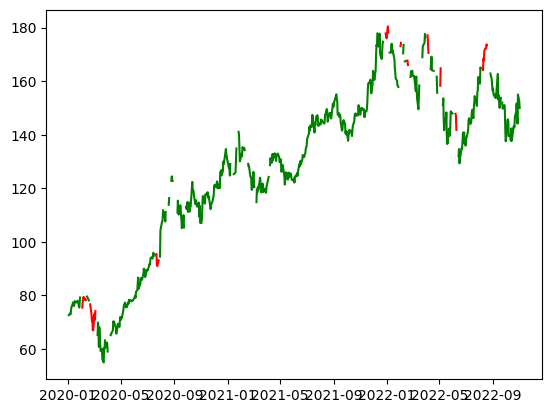

100%|██████████| 40/40 [00:08<00:00,  4.87it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

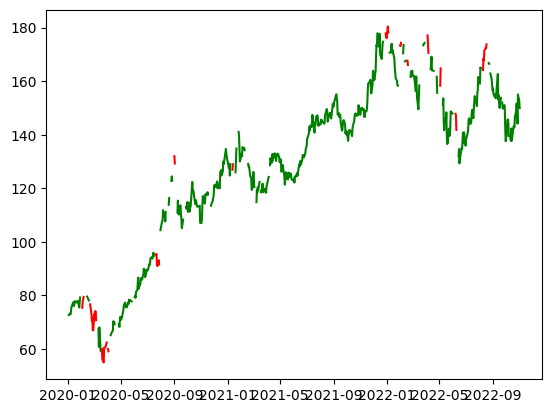

100%|██████████| 40/40 [00:08<00:00,  4.94it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

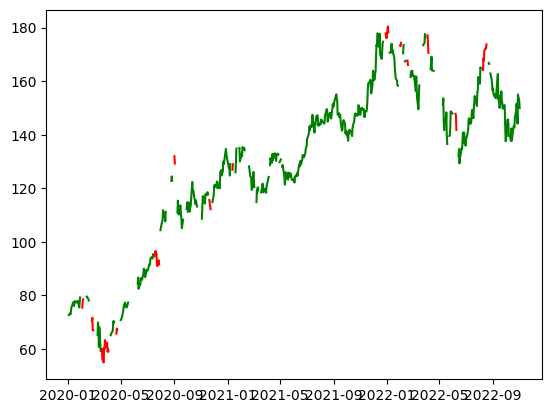

100%|██████████| 40/40 [00:08<00:00,  4.94it/s]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documents/GitHub/project-stonks/src/trader.py:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newdata = newdata[end>data['date']]
/Users/tylerdempski/Documen

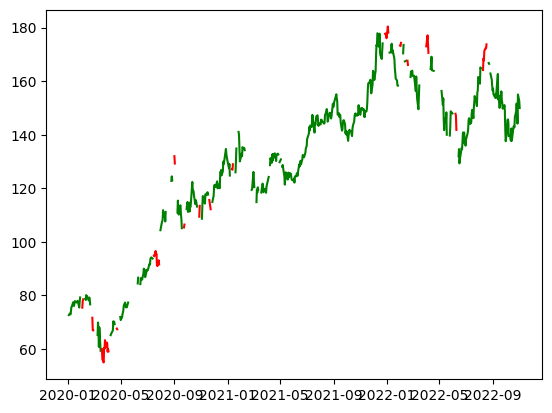

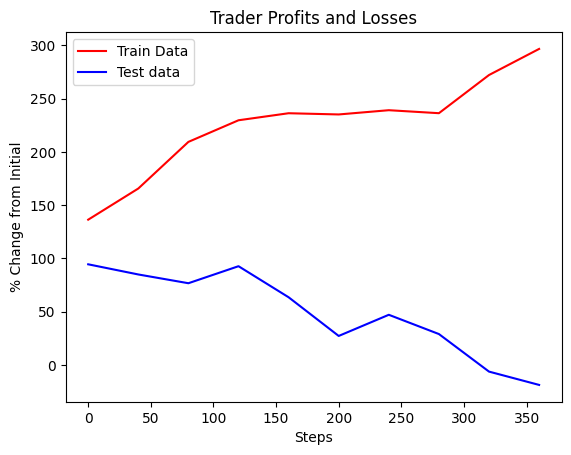

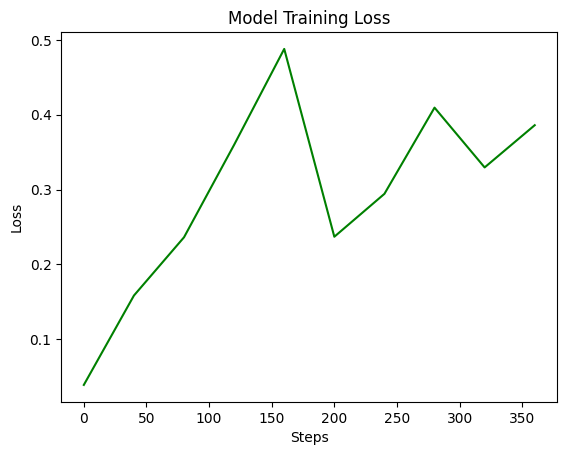

In [21]:
STEP_COUNT = 40
EPOCH_COUNT = 10
lstm = model.LSTMModel(torch.nn.ReLU(),WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT)
lstm.init_weights()
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()
kwargs = {
    "lr" : 0.001,
}
LSTMTrainer = trainer.LSTMTrainer(optimizer,lstm,loss_function,**kwargs)

input_data, label_data = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=True)
input_unnorm, label_unnorm = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=False)

test_data, test_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,binary=False,normalize=True,percent=True)
unnorm_data, unnorm_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,percent=True,normalize=False)


LSTMtrain, LSTMtest, LSTMLoss = evaluateLSTMModel(LSTMTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)

plotStats(LSTMtrain,LSTMtest,LSTMLoss,EPOCH_COUNT,STEP_COUNT)

In [16]:
STEP_COUNT = 50
EPOCH_COUNT = 5
cnn = model.CNNModel(1,WINDOW_SIZE,kernel_size=6)
cnn.init_weights()
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()
kwargs = {
    "lr" : 0.001,
   # "momentum" : 0.8
}
cnnTrainer = trainer.CNNTrainer(optimizer,cnn,loss_function,**kwargs)

input_data, label_data = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=True)
input_unnorm, label_unnorm = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=False)

test_data, test_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,binary=False,normalize=True,percent=True)
unnorm_data, unnorm_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,percent=True,normalize=False)


CNNtrain, CNNtest, CNNLoss = evaluateCNNModel(cnnTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)

plotStats(CNNtrain,CNNtest,CNNLoss,EPOCH_COUNT,STEP_COUNT)

KeyboardInterrupt: 

/Users/tylerdempski/miniconda3/envs/cs449/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


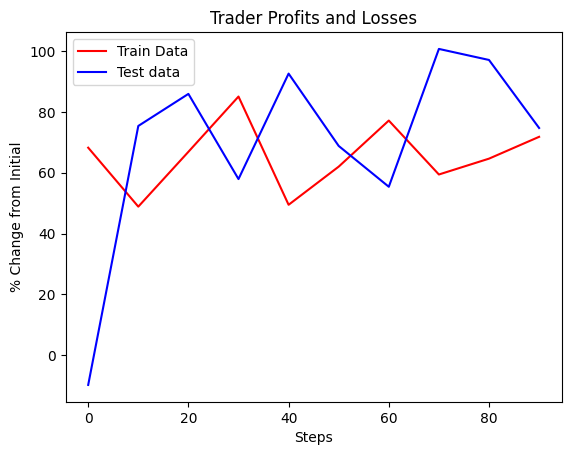

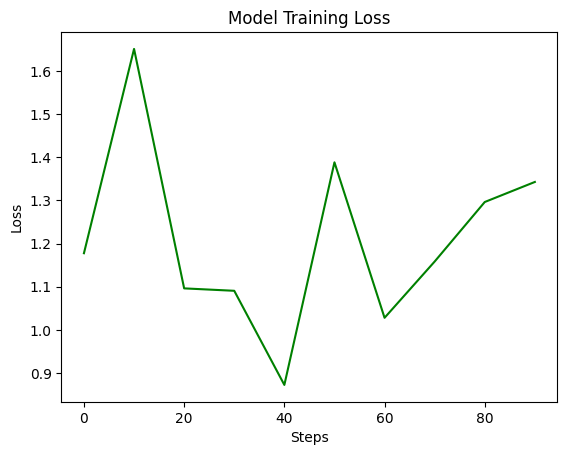

In [ ]:
STEP_COUNT = 10
EPOCH_COUNT = 10
hybrid = model.HybridModel(WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT,16,8,4)
hybrid.init_weights()
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()
kwargs = {
    "lr" : 0.01,
    #"momentum" : 0.8
}
HybridTrainer = trainer.HybridTrainer(optimizer,lstm,loss_function,**kwargs)

input_data, label_data = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=True)
input_unnorm, label_unnorm = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=False)

test_data, test_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,binary=False,normalize=True,percent=True)
unnorm_data, unnorm_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,percent=True,normalize=False)


Hybridtrain, Hybridtest, HybridLoss = evaluateHybridModel(HybridTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)

plotStats(Hybridtrain,Hybridtest,HybridLoss,EPOCH_COUNT,STEP_COUNT)

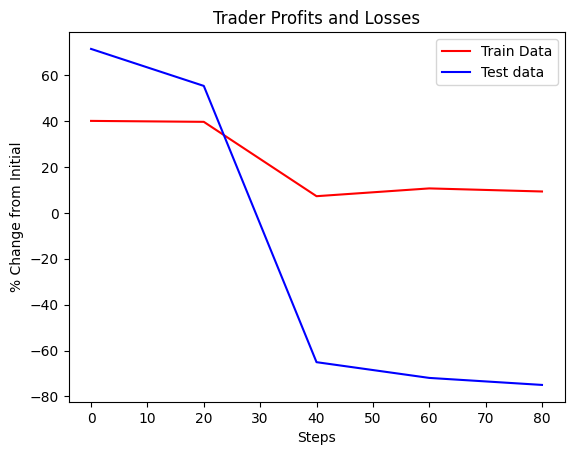

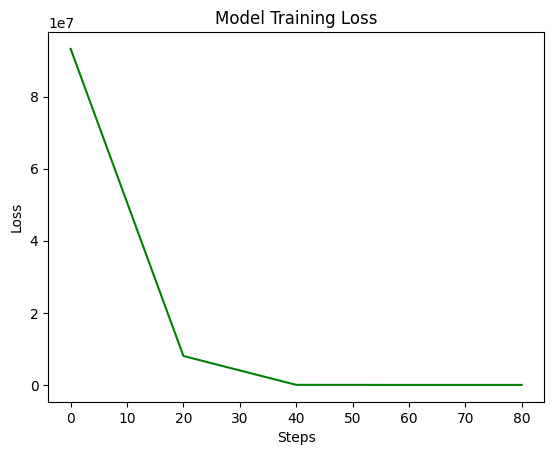

In [ ]:
STEP_COUNT = 20
EPOCH_COUNT = 5
MLP_DEPTH = 4
CNN_KERNEL = 6
HYBRID_PROJ = 16
HYBRID_CNN = 8
LAYER_COUNT = 2
ensemble = Ensemble(WINDOW_SIZE,HIDDEN_SIZE,LAYER_COUNT,CNN_KERNEL,HYBRID_PROJ,HYBRID_CNN,MLP_DEPTH)
ensemble.init_weights()
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()
kwargs = {
    "lr" : 0.00001
}
et = EnsembleTrainer(optimizer=optimizer,model=ensemble,loss_func=loss_function,**kwargs)

input_data, label_data = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=True)
input_unnorm, label_unnorm = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=False)

test_data, test_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,binary=False,normalize=True,percent=True)
unnorm_data, unnorm_labels = dataReader.readStockData(STOCK_FILE,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,percent=True,normalize=False)


Ensembletrain, Ensembletest, EnsembleLoss = evaluateEnsembleModel(et,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
plotStats(Ensembletrain,Ensembletest,EnsembleLoss,EPOCH_COUNT,STEP_COUNT)

  6%|▋         | 1/16 [04:32<1:08:04, 272.33s/it]

finished processing ../YFinanceStockData/AAL.csv


 12%|█▎        | 2/16 [09:06<1:03:46, 273.35s/it]

finished processing ../YFinanceStockData/AAPL.csv


 19%|█▉        | 3/16 [13:40<59:16, 273.55s/it]  

finished processing ../YFinanceStockData/MSFT.csv


 25%|██▌       | 4/16 [18:12<54:38, 273.24s/it]

finished processing ../YFinanceStockData/NVDA.csv


 31%|███▏      | 5/16 [22:39<49:40, 270.95s/it]

finished processing ../YFinanceStockData/GOOG.csv


 38%|███▊      | 6/16 [35:08<1:12:13, 433.35s/it]

finished processing ../YFinanceStockData/ABBV.csv


 44%|████▍     | 7/16 [57:05<1:48:20, 722.23s/it]

finished processing ../YFinanceStockData/AMD.csv


 50%|█████     | 8/16 [1:01:34<1:17:03, 577.96s/it]

finished processing ../YFinanceStockData/AMZN.csv


 56%|█████▋    | 9/16 [1:06:00<56:03, 480.54s/it]  

finished processing ../YFinanceStockData/JNJ.csv


 62%|██████▎   | 10/16 [1:10:27<41:26, 414.45s/it]

finished processing ../YFinanceStockData/JPM.csv


 69%|██████▉   | 11/16 [1:14:52<30:43, 368.67s/it]

finished processing ../YFinanceStockData/LUV.csv


 75%|███████▌  | 12/16 [1:19:13<22:24, 336.03s/it]

finished processing ../YFinanceStockData/MGM.csv


 81%|████████▏ | 13/16 [1:23:36<15:41, 313.76s/it]

finished processing ../YFinanceStockData/NFLX.csv


 88%|████████▊ | 14/16 [1:27:55<09:54, 297.32s/it]

finished processing ../YFinanceStockData/META.csv


 94%|█████████▍| 15/16 [1:32:18<04:46, 286.87s/it]

finished processing ../YFinanceStockData/QQQ.csv


100%|██████████| 16/16 [1:36:38<00:00, 362.43s/it]

finished processing ../YFinanceStockData/SPY.csv


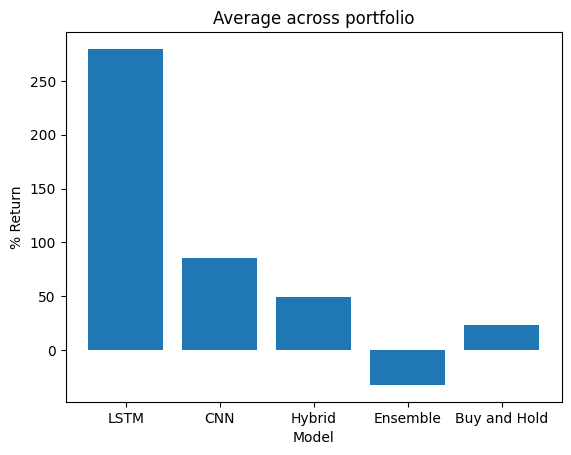

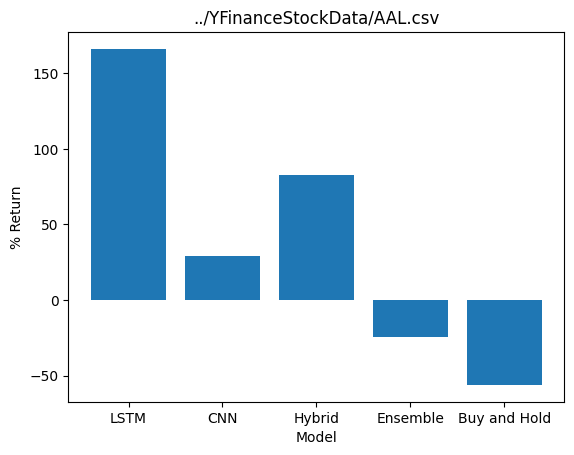

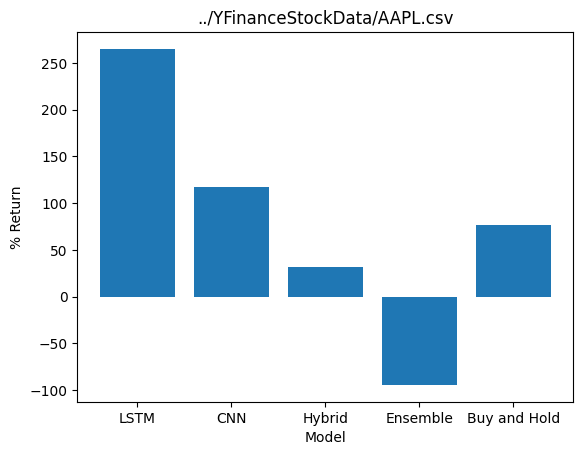

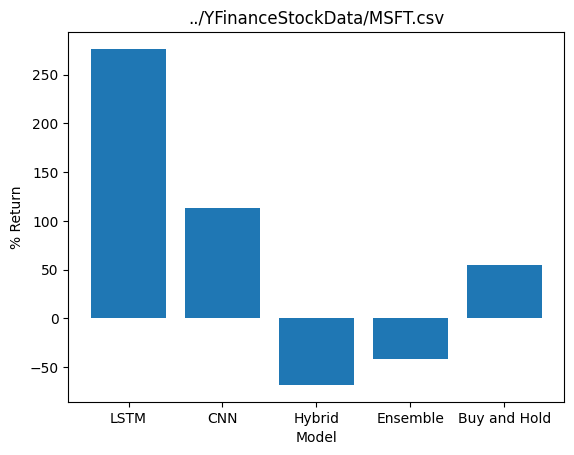

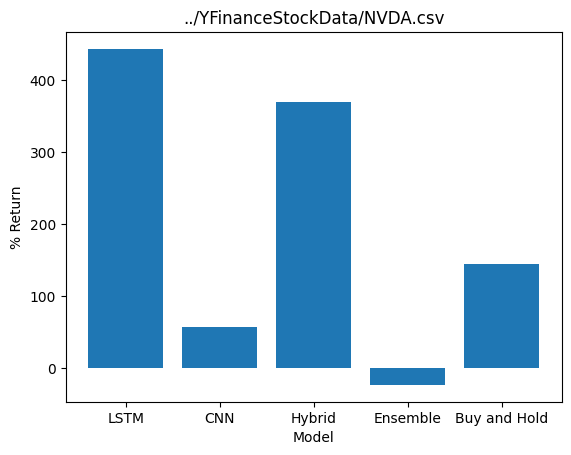

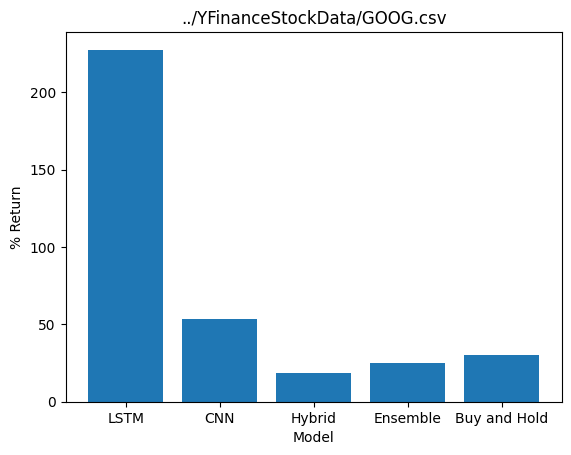

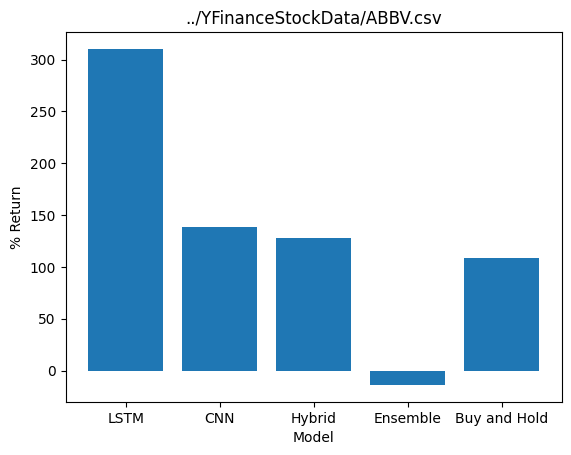

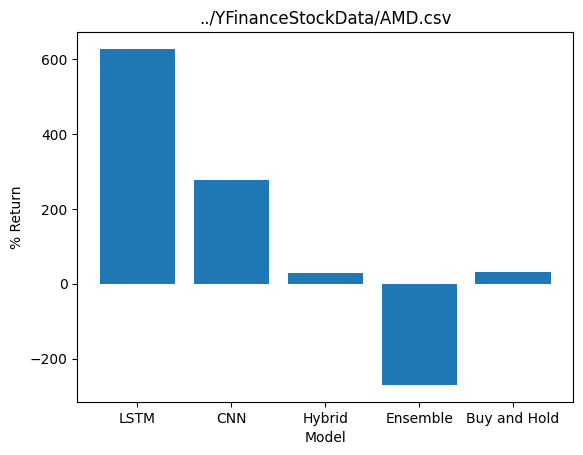

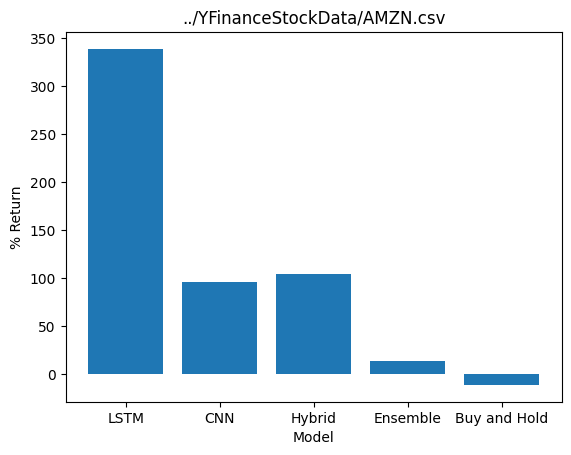

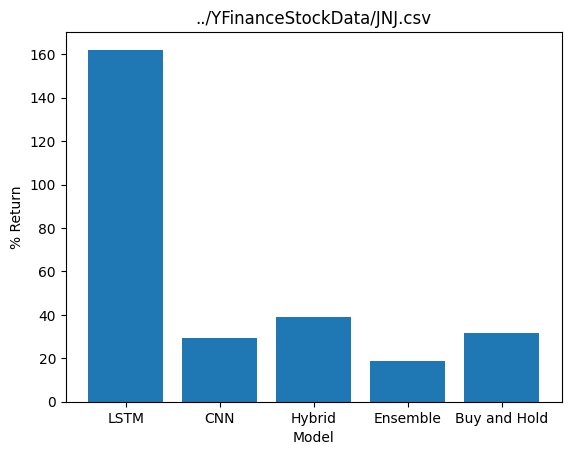

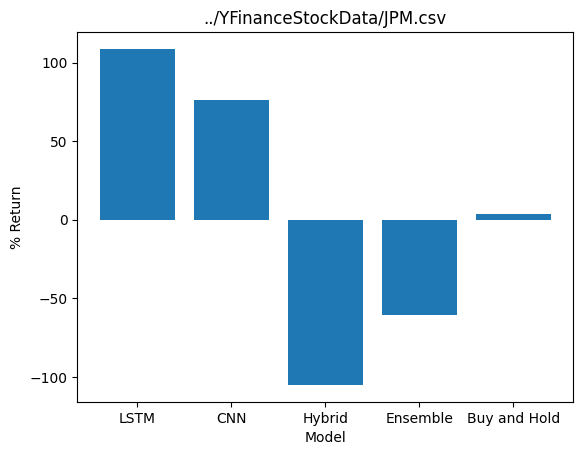

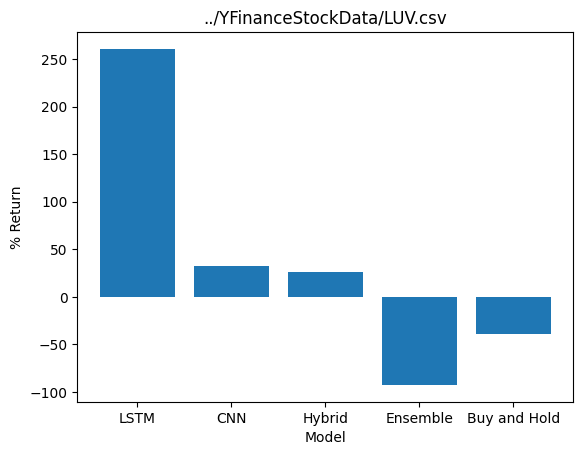

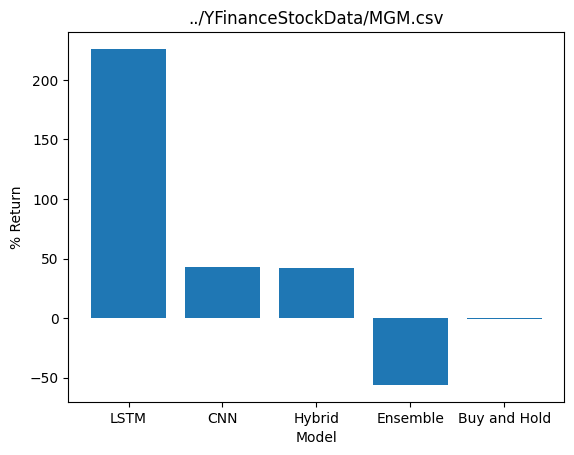

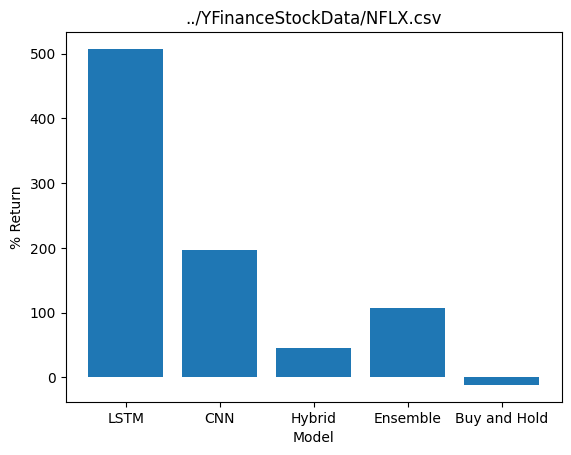

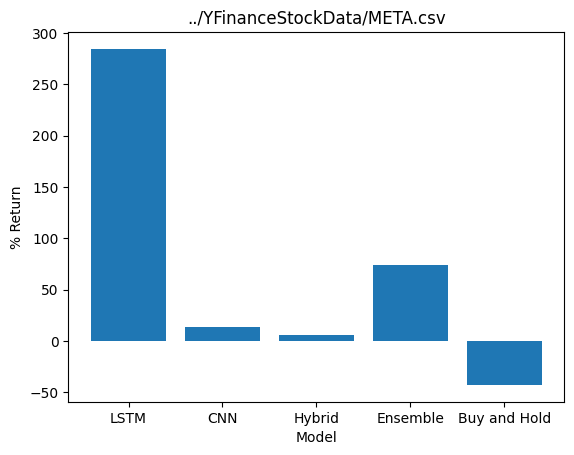

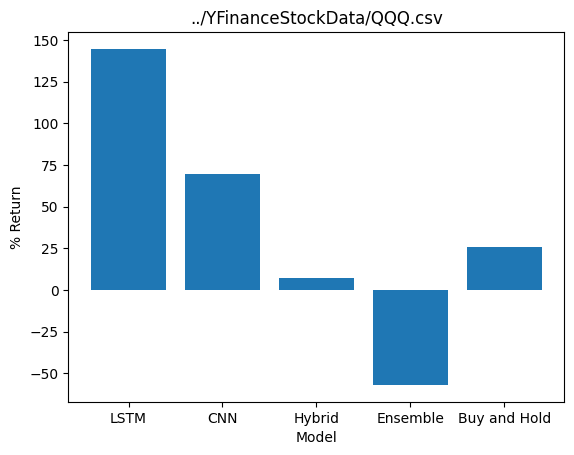

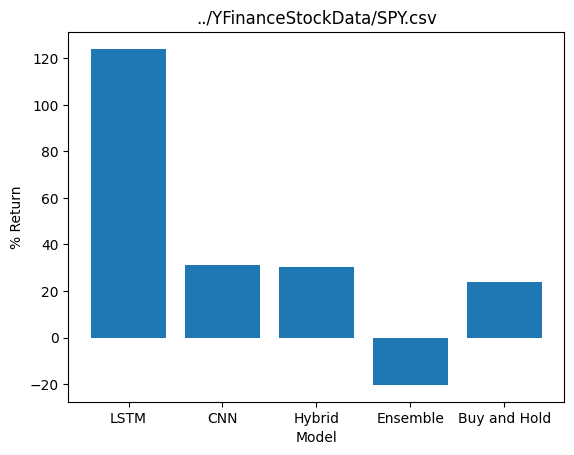

In [18]:
STOCKS = ['../YFinanceStockData/AAL.csv','../YFinanceStockData/AAPL.csv','../YFinanceStockData/MSFT.csv','../YFinanceStockData/NVDA.csv','../YFinanceStockData/GOOG.csv','../YFinanceStockData/ABBV.csv','../YFinanceStockData/AMD.csv','../YFinanceStockData/AMZN.csv','../YFinanceStockData/JNJ.csv','../YFinanceStockData/JPM.csv','../YFinanceStockData/LUV.csv','../YFinanceStockData/MGM.csv','../YFinanceStockData/NFLX.csv','../YFinanceStockData/META.csv','../YFinanceStockData/QQQ.csv','../YFinanceStockData/SPY.csv']
#Tech: Apple, Microsoft, Nvidia, Google, AMD
#Media/Social: Netflix, Twitter
#Airlines: American, Southwest, MGM
#Medicine: Abbvie, JnJ
#Finance: Chase
#Commerce: AMZN
#ETF: QQQ, SPY
averageLSTM, averageCNN, averageHybrid, averageEnsemble, avgBuyHold = 0 ,0 ,0 ,0, 0
LSTMChanges, CNNChanges, HybridChanges, EnsembleChanges, buyHoldChange = [],[],[],[], []
averageAVG = 0
averageChanges = []
STEPCOUNTGLOBAL = 1
for stock in tqdm(STOCKS):

    input_data, label_data = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=True)
    input_unnorm, label_unnorm = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=False)
    test_data, test_labels = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,binary=False,normalize=True,percent=True)
    unnorm_data, unnorm_labels = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,percent=True,normalize=False)
    ###LSTM###
    STEP_COUNT = 100
    EPOCH_COUNT = 5
    firstPrice = unnorm_data[0][0][0]
    lastPrice = unnorm_data[-1][0][WINDOW_SIZE-1]
    avgBuyHold += ((lastPrice-firstPrice)*100/firstPrice)/len(STOCKS)
    buyHoldChange.append((lastPrice-firstPrice)*100/firstPrice)
    
    lstm = model.LSTMModel(torch.nn.ReLU(),WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT)
    lstm.init_weights()
    optimizer = torch.optim.Adam
    loss_function = torch.nn.MSELoss()
    kwargs = {
        "lr" : 0.0001,
    }
    LSTMTrainer = trainer.LSTMTrainer(optimizer,lstm,loss_function,**kwargs)
    LSTMtrain, LSTMtest, LSTMLoss = evaluateLSTMModel(LSTMTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
    averageLSTM += LSTMtrain[-1]/len(STOCKS)
    LSTMChanges.append(LSTMtrain[-1])
    ###CNN###
    
    STEP_COUNT = 50
    EPOCH_COUNT = 5
    cnn = model.CNNModel(1,WINDOW_SIZE,kernel_size=6)
    cnn.init_weights()
    optimizer = torch.optim.Adam
    loss_function = torch.nn.MSELoss()
    kwargs = {
        "lr" : 0.0001,
        #"momentum" : 0.8
    }
    cnnTrainer = trainer.CNNTrainer(optimizer,cnn,loss_function,**kwargs)
    CNNtrain, CNNtest, CNNLoss = evaluateCNNModel(cnnTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
    averageCNN += CNNtrain[-1]/len(STOCKS)
    CNNChanges.append(CNNtrain[-1])
    ###Hybrid###
    STEP_COUNT = 10
    EPOCH_COUNT = 10
    hybrid = model.HybridModel(WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT,16,8,4)
    hybrid.init_weights()
    optimizer = torch.optim.Adam
    loss_function = torch.nn.MSELoss()
    kwargs = {
        "lr" : 0.01,
        #"momentum" : 0.8
    }
    HybridTrainer = trainer.HybridTrainer(optimizer,lstm,loss_function,**kwargs)
    Hybridtrain, Hybridtest, HybridLoss = evaluateHybridModel(HybridTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
    averageHybrid += Hybridtest[-1]/len(STOCKS)
    HybridChanges.append(Hybridtest[-1])
    STEP_COUNT = 25
    EPOCH_COUNT = 5
    MLP_DEPTH = 4
    CNN_KERNEL = 6
    HYBRID_PROJ = 16
    HYBRID_CNN = 8
    LAYER_COUNT = 2
    ensemble = Ensemble(WINDOW_SIZE,HIDDEN_SIZE,LAYER_COUNT,CNN_KERNEL,HYBRID_PROJ,HYBRID_CNN,MLP_DEPTH)
    ensemble.init_weights()
    optimizer = torch.optim.Adam
    loss_function = torch.nn.MSELoss()
    kwargs = {
        "lr" : 0.00001,
    }
    et = EnsembleTrainer(optimizer=optimizer,model=ensemble,loss_func=loss_function,**kwargs)
    Ensembletrain, Ensembletest, EnsembleLoss = evaluateEnsembleModel(et,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
    averageEnsemble += Ensembletest[-1]/len(STOCKS)
    EnsembleChanges.append(Ensembletest[-1])
    print(f"finished processing {stock}")

xaxis = ['LSTM','CNN','Hybrid','Ensemble','Buy and Hold']
data = [averageLSTM,averageCNN,averageHybrid,averageEnsemble,avgBuyHold]
plt.bar(xaxis,data)
plt.title("Average across portfolio")
plt.xlabel('Model')
plt.ylabel('% Return')
plt.show()

for stock in range(len(STOCKS)):
    #sdata = [LSTMChanges[stock],CNNChanges[stock],HybridChanges[stock],EnsembleChanges[stock],buyHoldChange[stock]]
    sdata = [LSTMChanges[stock],CNNChanges[stock],HybridChanges[stock],EnsembleChanges[stock],buyHoldChange[stock].item()]
    plt.bar(xaxis,sdata)
    plt.xlabel('Model')
    plt.ylabel('% Return')
    plt.title(STOCKS[stock])
    plt.show()

            

In [19]:
###Overnight code for running a shitload of stuff, basically a true performance test
###Train on three years, run on three next. Rinse and repeat. Looking at roughly an hour per window
LSTMyears, CNNyears, Hybridyears, BHyears, EnsembleYears = [] ,[] ,[] ,[] , []
years = ['2015','2016','2017','2018','2019','2020']
startYears = ['2012-1-1','2013-1-1','2014-1-1','2015-1-1','2016-1-1','2017-1-1','2018-1-1','2019-1-1','2020-1-1','2021-1-1','2022-1-1']

for index in range(6):
    START_DATE = startYears[index]
    TEST_START_DATE = startYears[index]
    DATE_RANGE = 365*3
    averageLSTM, averageCNN, averageHybrid, averageEnsemble, avgBuyHold = 0 ,0 ,0 ,0, 0
    LSTMChanges, CNNChanges, HybridChanges, EnsembleChanges, buyHoldChange = [],[],[],[], []
    for stock in tqdm(STOCKS):
        input_data, label_data = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=True)
        input_unnorm, label_unnorm = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,START_DATE,DATE_RANGE,binary=False,percent=True,normalize=False)
        test_data, test_labels = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,binary=False,normalize=True,percent=True)
        unnorm_data, unnorm_labels = dataReader.readStockData(stock,WINDOW_SIZE,PREDICTION_OFFSET,TEST_START_DATE,DATE_RANGE,percent=True,normalize=False)
        ###LSTM###
        STEP_COUNT = 100
        EPOCH_COUNT = 5
        firstPrice = unnorm_data[0][0][0]
        lastPrice = unnorm_data[-1][0][WINDOW_SIZE-1]
        avgBuyHold += ((lastPrice-firstPrice)*100/firstPrice)/len(STOCKS)
        buyHoldChange.append((lastPrice-firstPrice)*100/firstPrice)
        
        lstm = model.LSTMModel(torch.nn.ReLU(),WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT)
        lstm.init_weights()
        optimizer = torch.optim.Adam
        loss_function = torch.nn.MSELoss()
        kwargs = {
            "lr" : 0.0001,
        }
        LSTMTrainer = trainer.LSTMTrainer(optimizer,lstm,loss_function,**kwargs)
        LSTMtrain, LSTMtest, LSTMLoss = evaluateLSTMModel(LSTMTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
        averageLSTM += LSTMtrain[-1]/len(STOCKS)
        LSTMChanges.append(LSTMtrain[-1])
        ###CNN###
        
        STEP_COUNT = 50
        EPOCH_COUNT = 5
        cnn = model.CNNModel(1,WINDOW_SIZE,kernel_size=6)
        cnn.init_weights()
        optimizer = torch.optim.Adam
        loss_function = torch.nn.MSELoss()
        kwargs = {
            "lr" : 0.0001,
            #"momentum" : 0.8
        }
        cnnTrainer = trainer.CNNTrainer(optimizer,cnn,loss_function,**kwargs)
        CNNtrain, CNNtest, CNNLoss = evaluateCNNModel(cnnTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
        averageCNN += CNNtrain[-1]/len(STOCKS)
        CNNChanges.append(CNNtrain[-1])
        ###Hybrid###
        STEP_COUNT = 10
        EPOCH_COUNT = 10
        hybrid = model.HybridModel(WINDOW_SIZE,HIDDEN_SIZE,HIDDEN_COUNT,16,8,4)
        hybrid.init_weights()
        optimizer = torch.optim.Adam
        loss_function = torch.nn.MSELoss()
        kwargs = {
            "lr" : 0.01,
            #"momentum" : 0.8
        }
        HybridTrainer = trainer.HybridTrainer(optimizer,lstm,loss_function,**kwargs)
        Hybridtrain, Hybridtest, HybridLoss = evaluateHybridModel(HybridTrainer,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
        averageHybrid += Hybridtest[-1]/len(STOCKS)
        HybridChanges.append(Hybridtest[-1])
        STEP_COUNT = 25
        EPOCH_COUNT = 5
        MLP_DEPTH = 4
        CNN_KERNEL = 6
        HYBRID_PROJ = 16
        HYBRID_CNN = 8
        LAYER_COUNT = 2
        ensemble = Ensemble(WINDOW_SIZE,HIDDEN_SIZE,LAYER_COUNT,CNN_KERNEL,HYBRID_PROJ,HYBRID_CNN,MLP_DEPTH)
        ensemble.init_weights()
        optimizer = torch.optim.Adam
        loss_function = torch.nn.MSELoss()
        kwargs = {
            "lr" : 0.00001,
        }
        et = EnsembleTrainer(optimizer=optimizer,model=ensemble,loss_func=loss_function,**kwargs)
        Ensembletrain, Ensembletest, EnsembleLoss = evaluateEnsembleModel(et,STEP_COUNT,EPOCH_COUNT,input_data,label_data,test_data,input_unnorm,unnorm_data)
        averageEnsemble += Ensembletest[-1]/len(STOCKS)
        EnsembleChanges.append(Ensembletest[-1])
    LSTMyears.append(averageLSTM)
    CNNyears.append(averageCNN)
    Hybridyears.append(averageHybrid)
    EnsembleYears.append(averageEnsemble)
    BHyears.append(avgBuyHold)

100%|██████████| 16/16 [1:09:27<00:00, 260.46s/it]


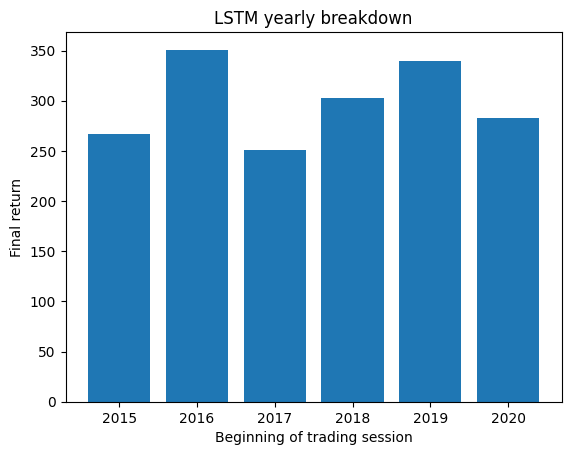

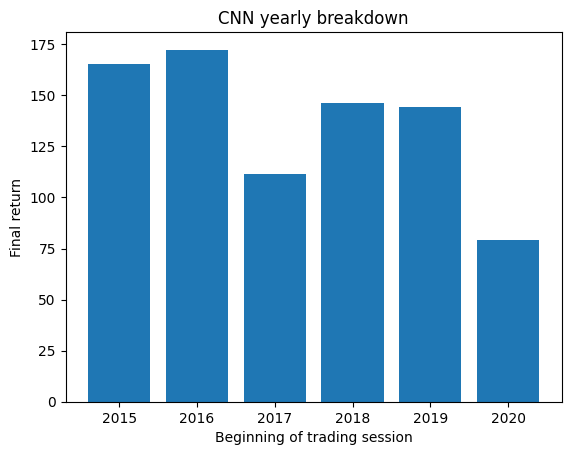

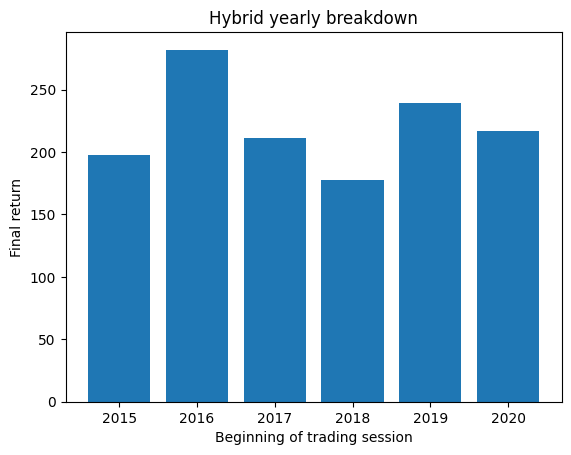

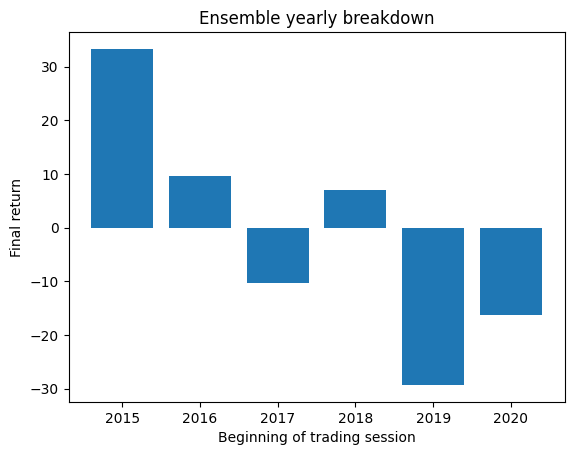

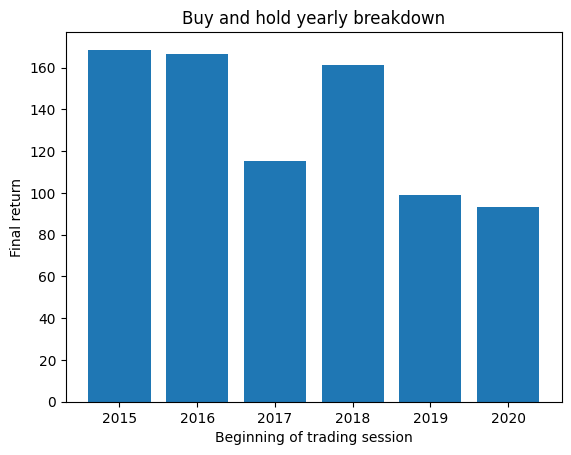

In [20]:
plt.bar(years,LSTMyears)
plt.title("LSTM yearly breakdown")
plt.xlabel("Beginning of trading session")
plt.ylabel("Final return")
plt.show()
plt.bar(years,CNNyears)
plt.title("CNN yearly breakdown")
plt.xlabel("Beginning of trading session")
plt.ylabel("Final return")
plt.show()
plt.bar(years,Hybridyears)
plt.title("Hybrid yearly breakdown")
plt.xlabel("Beginning of trading session")
plt.ylabel("Final return")
plt.show()
plt.bar(years,EnsembleYears)
plt.title("Ensemble yearly breakdown")
plt.xlabel("Beginning of trading session")
plt.ylabel("Final return")
plt.show()
plt.bar(years,BHyears)
plt.title("Buy and hold yearly breakdown")
plt.xlabel("Beginning of trading session")
plt.ylabel("Final return")
plt.show()